In [172]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from PDE_solver_backend import Aggregate,PDESolver

In [174]:
def make_points_inside(Nd,range_model=np.array([[-1,1],[-1,1]])):
    assert range_model.shape==(2,2) and np.all(range_model[:,1:]-range_model[:,:1]>=0)
    clipped=np.clip(range_model,-1,1)

    return (clipped[:,1:]-clipped[:,:1]).T*np.random.rand(Nd,2)+clipped[:,:1].T

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

def make_points_on_specific_boundary(Nb,which_axis,which_side,range_model=np.array([-1,1])):
    assert which_axis in {'x','y'}
    assert which_side in {-1,1}
    assert range_model.shape==(2,) and range_model[1]-range_model[0]>=0
    X=np.zeros((Nb,2))
    num_axis=int(which_axis=='y')
    X[:,num_axis]=which_side
    X[:,1-num_axis]=np.random.rand(Nb)*(range_model[1]-range_model[0])+range_model[0]
    return X

def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def dumb_aggregate(x,models,width):
    modified=(x+1)/2*width
    indexes=modified.astype(np.int32)
    which_model=indexes[:,0]+width*indexes[:,1]
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model(x[which_model==i])
    return res



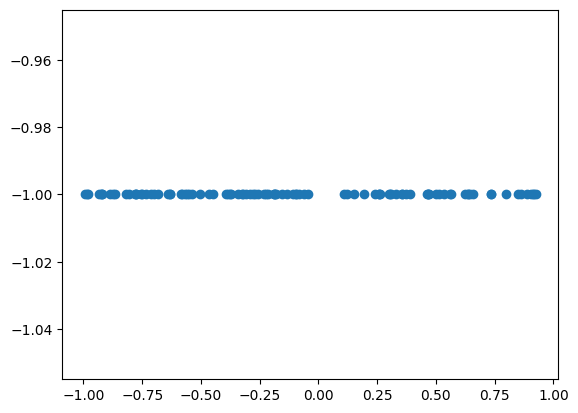

In [175]:
range_neighbor=np.array([
    [-1,1],
    [-1,-1]
])
X_shared=make_points_inside(100,range_neighbor)
plt.scatter(X_shared[:,0],X_shared[:,1])

In [176]:
from sympy import cos,sin,pi,symbols,diff,lambdify,exp

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=-laplacian(u_symbolic)+u_symbolic**3
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.power(x,3)
dtau=lambda x:3*x**2
#tau=lambda x:np.zeros_like(x)
#dtau=lambda x:np.zeros_like(x)
u_symbolic

cos(4*pi*x)*cos(pi*y/2)

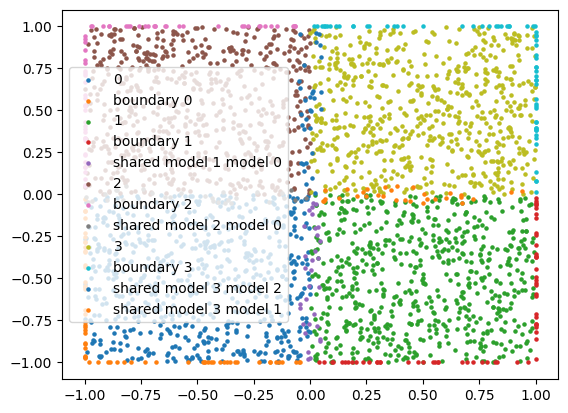

In [177]:
int_point_number=2500
ext_point_number=500
width=2
int_point_per_model=int_point_number//width**2
ext_point_per_model=ext_point_number//width**2

sigma=0.1
boundary_width=0.05

models=[]
for i in range(width**2):
    yi=i//width
    xi=i%width
    range_model=np.array([
        [-1+2*xi/width,-1+2*(xi+1)/width],
        [-1+2*yi/width,-1+2*(yi+1)/width]
    ])
    X_int=make_points_inside(int_point_per_model,range_model)
    X_bounds=[]
    if i%width==0:
        range_boundary=np.array([
            [-1,-1],
            [-1+2*yi/width,-1+2*(yi+1)/width]
        ])
        X_bounds.append(make_points_inside(ext_point_per_model//4,range_boundary))
    if i%width==width-1:
        range_boundary=np.array([
            [1,1],
            [-1+2*yi/width,-1+2*(yi+1)/width]
        ])
        X_bounds.append(make_points_inside(ext_point_per_model//4,range_boundary))
    if i//width==0:
        range_boundary=np.array([
            [-1+2*xi/width,-1+2*(xi+1)/width],
            [-1,-1]
        ])
        X_bounds.append(make_points_inside(ext_point_per_model//4,range_boundary))
    if i//width==width-1:
        range_boundary=np.array([
            [-1+2*xi/width,-1+2*(xi+1)/width],
            [1,1]
        ])
        X_bounds.append(make_points_inside(ext_point_per_model//4,range_boundary))

    plt.scatter(X_int[:,0],X_int[:,1],label=f'{i}',s=5)

    try:
        X_boundary=np.concatenate(X_bounds)
        plt.scatter(X_boundary[:,0],X_boundary[:,1],label=f'boundary {i}',s=5)
    except ValueError:
        X_boundary=np.empty((0,2))
    
    models.append(
        PDESolver(
            X_int=X_int,
            X_boundary=X_boundary,
            sigma=sigma,
            name=f'model {i}')
    )
    if i%width>0:
        range_neighbor=np.array([
            [-1+2*xi/width-boundary_width,-1+2*(xi)/width+boundary_width],
            [-1+2*yi/width,-1+2*(yi+1)/width]
        ])
        X_shared=make_points_inside(ext_point_per_model//4,range_neighbor)
        models[-1].add_neighbors([models[-2]], [X_shared])
        models[-2].add_neighbors([models[-1]], [X_shared])
        plt.scatter(X_shared[:,0],X_shared[:,1],label=f'shared {models[-1]} {models[-2]}',s=5)
    if i//width>0:
        range_neighbor=np.array([
            [-1+2*xi/width,-1+2*(xi+1)/width],
            [-1+2*yi/width-boundary_width,-1+2*(yi)/width+boundary_width]
        ])
        X_shared=make_points_inside(ext_point_per_model//4,range_neighbor)
        models[-1].add_neighbors([models[-1-width]], [X_shared])
        models[-1-width].add_neighbors([models[-1]], [X_shared])
        plt.scatter(X_shared[:,0],X_shared[:,1],label=f'shared {models[-1]} {models[-1-width]}',s=5)

plt.legend()
plt.show()

In [178]:
print(models[0].X_all.shape)

(749, 2)


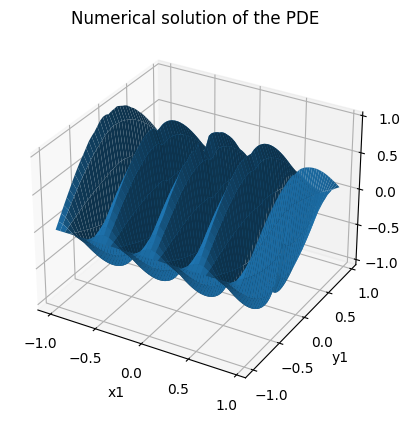

  0%|          | 0/10 [00:00<?, ?it/s]

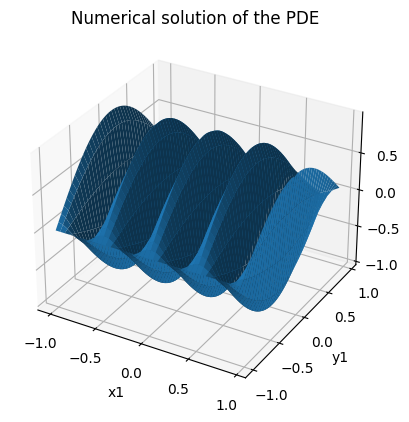

 10%|█         | 1/10 [00:01<00:16,  1.85s/it]

{model 1: array([0.97261649, 0.7363909 , 0.74176323, 0.65203103, 0.16927203,
       0.53990334, 0.80320449, 0.4379794 , 0.96599038, 0.25750376,
       0.42807322, 0.09850772, 0.32301532, 0.97548103, 0.30567597,
       0.75609092, 0.89210594, 0.04095308, 0.92104585, 0.03020766,
       0.39786812, 0.56179717, 0.9748356 , 0.83046543, 0.77198085,
       0.84686363, 0.80034809, 0.90631681, 0.34547167, 0.18530969,
       0.84379694]), model 2: array([ 0.99755512,  0.62210061,  0.59800405, -0.66669943, -0.99470968,
       -0.65342192,  0.64699236, -0.00199379,  0.41419399, -0.9988972 ,
       -0.29559414,  0.92279125, -0.16557456,  0.48827273,  0.03198554,
       -0.23864019, -0.15057366,  0.2961833 , -0.20878522,  0.03705239,
       -0.56820317,  0.15518905,  0.66594718, -0.83155142,  0.12288725,
        0.96385708,  0.90743731, -0.55548779, -0.99821297,  0.98070685,
        0.40387636])}


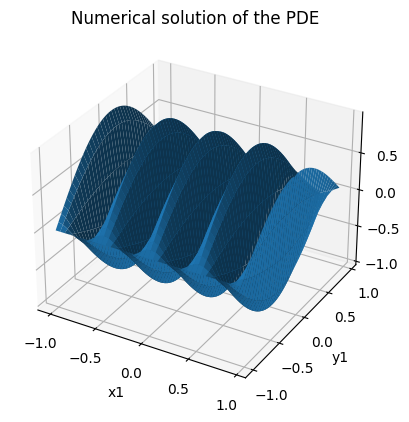

 20%|██        | 2/10 [00:03<00:14,  1.78s/it]

{model 1: array([0.97364546, 0.73715233, 0.74245292, 0.6525873 , 0.16941898,
       0.54035873, 0.80395021, 0.43838989, 0.96697566, 0.25770351,
       0.42841468, 0.09857865, 0.32327864, 0.97648518, 0.3059263 ,
       0.75676736, 0.89305794, 0.04098288, 0.92206675, 0.03023013,
       0.39824681, 0.56234294, 0.97584843, 0.83127432, 0.77284736,
       0.84776564, 0.80112654, 0.90725794, 0.34573453, 0.18546974,
       0.84473948]), model 2: array([ 0.99757138,  0.62290406,  0.59870711, -0.66645469, -0.99376697,
       -0.65246148,  0.64798919, -0.00102287,  0.4149979 , -0.99854244,
       -0.29474626,  0.92283731, -0.16538635,  0.48924563,  0.03280861,
       -0.23812713, -0.14973739,  0.29631997, -0.20859121,  0.03761595,
       -0.56733336,  0.15598624,  0.66674551, -0.8311377 ,  0.1238652 ,
        0.96488347,  0.90825109, -0.55525509, -0.99787846,  0.98072677,
        0.40400173])}


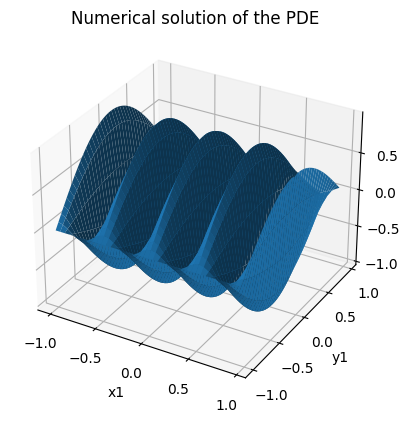

 30%|███       | 3/10 [00:05<00:13,  1.90s/it]

{model 1: array([0.97346639, 0.73701907, 0.74233282, 0.65249076, 0.1693928 ,
       0.54028048, 0.80382015, 0.43831917, 0.96680193, 0.25766827,
       0.42835475, 0.09856566, 0.32323219, 0.97630874, 0.30588215,
       0.75664956, 0.89289281, 0.04097752, 0.92188842, 0.03022613,
       0.39818109, 0.56224771, 0.97567077, 0.83113329, 0.7726963 ,
       0.84760908, 0.8009911 , 0.90709395, 0.34568812, 0.18544144,
       0.84457473]), model 2: array([ 0.99757098,  0.62279247,  0.59862918, -0.66650018, -0.99392329,
       -0.65262594,  0.6478141 , -0.00119235,  0.41487981, -0.99860593,
       -0.29487605,  0.92283008, -0.16542045,  0.48907299,  0.03268337,
       -0.23821026, -0.14986523,  0.2962952 , -0.20862611,  0.03753308,
       -0.56746777,  0.15586146,  0.6666357 , -0.83121151,  0.12369452,
        0.96470396,  0.90815494, -0.55529756, -0.99793831,  0.98072339,
        0.40397906])}


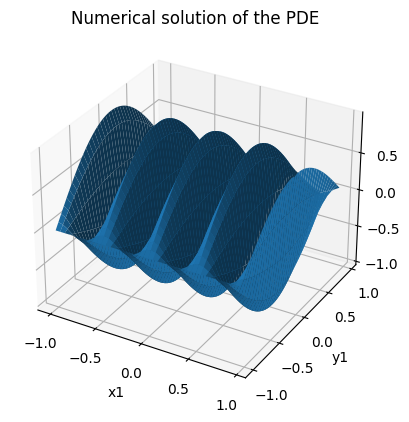

 40%|████      | 4/10 [00:07<00:11,  1.93s/it]

{model 1: array([0.97349757, 0.73704244, 0.74235394, 0.65250778, 0.16939739,
       0.54029434, 0.80384299, 0.43833169, 0.96683205, 0.25767447,
       0.42836531, 0.09856793, 0.32324037, 0.97633935, 0.30588992,
       0.75667026, 0.89292169, 0.04097846, 0.92191941, 0.03022683,
       0.39819271, 0.56226447, 0.97570161, 0.83115802, 0.77272273,
       0.84763647, 0.80101491, 0.90712257, 0.34569629, 0.18544642,
       0.84460345]), model 2: array([ 0.99757114,  0.62281523,  0.59864773, -0.66649187, -0.99389503,
       -0.65259683,  0.64784453, -0.00116277,  0.41490307, -0.9985943 ,
       -0.29485119,  0.92283146, -0.16541421,  0.48910286,  0.03270745,
       -0.2381948 , -0.14984073,  0.29629976, -0.20861971,  0.0375495 ,
       -0.56744218,  0.15588507,  0.66665821, -0.83119833,  0.12372432,
        0.96473518,  0.9081767 , -0.55528974, -0.99792724,  0.98072403,
        0.4039832 ])}


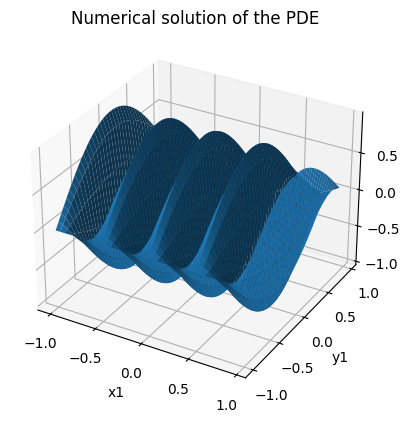

 50%|█████     | 5/10 [00:09<00:09,  1.91s/it]

{model 1: array([0.97349213, 0.73703838, 0.74235027, 0.65250482, 0.16939659,
       0.54029194, 0.80383902, 0.43832952, 0.96682678, 0.25767339,
       0.42836347, 0.09856753, 0.32323895, 0.976334  , 0.30588857,
       0.75666667, 0.89291666, 0.04097829, 0.921914  , 0.03022671,
       0.3981907 , 0.56226156, 0.97569622, 0.83115372, 0.77271813,
       0.84763171, 0.80101077, 0.90711759, 0.34569487, 0.18544556,
       0.84459845]), model 2: array([ 0.99757112,  0.6228116 ,  0.598645  , -0.6664933 , -0.99389985,
       -0.65260186,  0.64783922, -0.00116791,  0.41489929, -0.99859629,
       -0.29485529,  0.92283123, -0.16541528,  0.48909764,  0.03270349,
       -0.23819741, -0.14984477,  0.29629898, -0.20862081,  0.03754682,
       -0.56744641,  0.15588115,  0.66665464, -0.83120062,  0.12371913,
        0.96472973,  0.90817342, -0.55529107, -0.99792913,  0.98072392,
        0.40398249])}


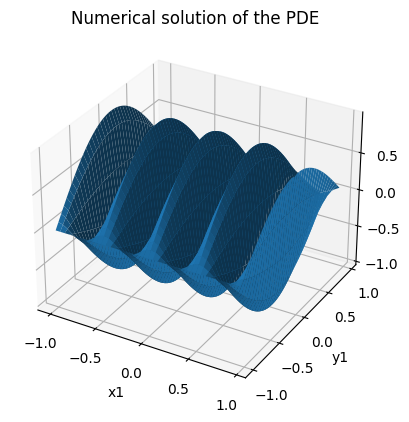

 60%|██████    | 6/10 [00:11<00:07,  1.88s/it]

{model 1: array([0.97349308, 0.73703909, 0.74235091, 0.65250534, 0.16939673,
       0.54029236, 0.80383972, 0.4383299 , 0.9668277 , 0.25767358,
       0.42836379, 0.0985676 , 0.32323919, 0.97633493, 0.30588881,
       0.75666729, 0.89291754, 0.04097832, 0.92191494, 0.03022673,
       0.39819105, 0.56226207, 0.97569716, 0.83115447, 0.77271893,
       0.84763254, 0.8010115 , 0.90711846, 0.34569512, 0.18544571,
       0.84459932]), model 2: array([ 0.99757113,  0.62281227,  0.59864553, -0.66649305, -0.99389899,
       -0.65260097,  0.64784014, -0.00116702,  0.41489997, -0.99859594,
       -0.29485455,  0.92283127, -0.16541509,  0.48909855,  0.0327042 ,
       -0.23819695, -0.14984404,  0.29629912, -0.20862061,  0.03754731,
       -0.56744565,  0.15588185,  0.6666553 , -0.83120022,  0.12372004,
        0.96473068,  0.90817405, -0.55529083, -0.99792879,  0.98072394,
        0.40398261])}


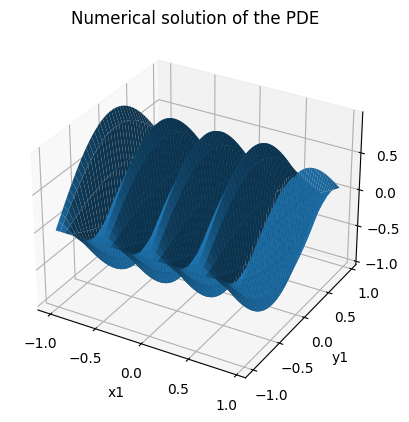

 70%|███████   | 7/10 [00:13<00:05,  1.86s/it]

{model 1: array([0.97349292, 0.73703897, 0.7423508 , 0.65250525, 0.16939671,
       0.54029229, 0.8038396 , 0.43832984, 0.96682754, 0.25767355,
       0.42836374, 0.09856759, 0.32323915, 0.97633477, 0.30588877,
       0.75666719, 0.89291739, 0.04097832, 0.92191478, 0.03022672,
       0.39819099, 0.56226198, 0.975697  , 0.83115434, 0.77271879,
       0.84763239, 0.80101137, 0.9071183 , 0.34569507, 0.18544568,
       0.84459917]), model 2: array([ 0.99757113,  0.62281215,  0.59864545, -0.66649309, -0.99389914,
       -0.65260113,  0.64783998, -0.00116717,  0.41489986, -0.998596  ,
       -0.29485468,  0.92283127, -0.16541512,  0.48909839,  0.03270408,
       -0.23819703, -0.14984416,  0.29629909, -0.20862065,  0.03754722,
       -0.56744578,  0.15588173,  0.66665518, -0.83120029,  0.12371988,
        0.96473051,  0.90817394, -0.55529088, -0.99792885,  0.98072394,
        0.40398259])}


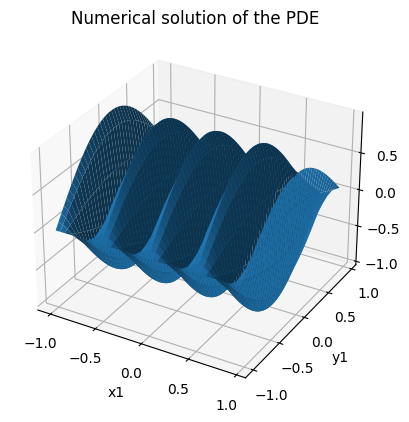

 80%|████████  | 8/10 [00:15<00:03,  1.90s/it]

{model 1: array([0.97349294, 0.73703899, 0.74235082, 0.65250526, 0.16939671,
       0.5402923 , 0.80383962, 0.43832985, 0.96682757, 0.25767355,
       0.42836375, 0.09856759, 0.32323916, 0.9763348 , 0.30588877,
       0.7566672 , 0.89291741, 0.04097832, 0.92191481, 0.03022673,
       0.398191  , 0.56226199, 0.97569703, 0.83115436, 0.77271882,
       0.84763242, 0.80101139, 0.90711833, 0.34569508, 0.18544569,
       0.8445992 ]), model 2: array([ 0.99757113,  0.62281217,  0.59864546, -0.66649308, -0.99389912,
       -0.6526011 ,  0.64784001, -0.00116714,  0.41489988, -0.99859599,
       -0.29485466,  0.92283127, -0.16541512,  0.48909842,  0.0327041 ,
       -0.23819702, -0.14984414,  0.2962991 , -0.20862064,  0.03754724,
       -0.56744576,  0.15588175,  0.6666552 , -0.83120028,  0.12371991,
        0.96473054,  0.90817396, -0.55529087, -0.99792884,  0.98072394,
        0.4039826 ])}


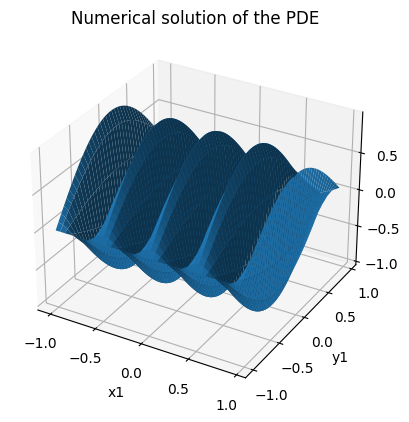

 90%|█████████ | 9/10 [00:17<00:01,  1.90s/it]

{model 1: array([0.97349294, 0.73703898, 0.74235081, 0.65250526, 0.16939671,
       0.5402923 , 0.80383961, 0.43832985, 0.96682756, 0.25767355,
       0.42836374, 0.09856759, 0.32323916, 0.9763348 , 0.30588877,
       0.7566672 , 0.89291741, 0.04097832, 0.9219148 , 0.03022672,
       0.398191  , 0.56226199, 0.97569702, 0.83115436, 0.77271881,
       0.84763241, 0.80101139, 0.90711833, 0.34569508, 0.18544569,
       0.84459919]), model 2: array([ 0.99757113,  0.62281217,  0.59864546, -0.66649308, -0.99389912,
       -0.65260111,  0.64784   , -0.00116715,  0.41489987, -0.99859599,
       -0.29485466,  0.92283127, -0.16541512,  0.48909841,  0.0327041 ,
       -0.23819702, -0.14984415,  0.2962991 , -0.20862064,  0.03754723,
       -0.56744576,  0.15588175,  0.6666552 , -0.83120028,  0.1237199 ,
        0.96473054,  0.90817396, -0.55529087, -0.99792884,  0.98072394,
        0.40398259])}


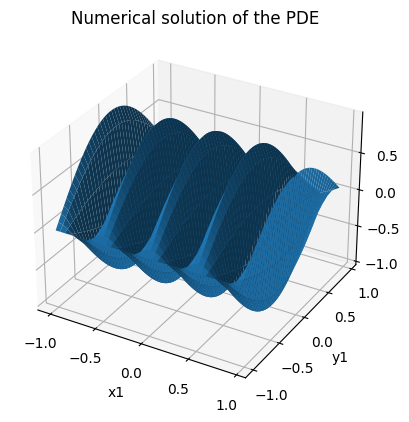

100%|██████████| 10/10 [00:19<00:00,  1.92s/it]

{model 1: array([0.97349294, 0.73703898, 0.74235081, 0.65250526, 0.16939671,
       0.5402923 , 0.80383962, 0.43832985, 0.96682757, 0.25767355,
       0.42836375, 0.09856759, 0.32323916, 0.9763348 , 0.30588877,
       0.7566672 , 0.89291741, 0.04097832, 0.9219148 , 0.03022672,
       0.398191  , 0.56226199, 0.97569702, 0.83115436, 0.77271881,
       0.84763242, 0.80101139, 0.90711833, 0.34569508, 0.18544569,
       0.84459919]), model 2: array([ 0.99757113,  0.62281217,  0.59864546, -0.66649308, -0.99389912,
       -0.6526011 ,  0.64784   , -0.00116715,  0.41489988, -0.99859599,
       -0.29485466,  0.92283127, -0.16541512,  0.48909841,  0.0327041 ,
       -0.23819702, -0.14984415,  0.2962991 , -0.20862064,  0.03754724,
       -0.56744576,  0.15588175,  0.6666552 , -0.83120028,  0.1237199 ,
        0.96473054,  0.90817396, -0.55529087, -0.99792884,  0.98072394,
        0.4039826 ])}


In [179]:
for model in models:
    model.fit_interior(f,real_u,tau,dtau,use_shared=False,nugget=1e-5)
PDESolver.joint_fit_boundaries(models)
local_aggregate=partial(dumb_aggregate,models=models,width=width)
fig=plot_vectorized_function(local_aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()
for i in tqdm(range(10)):
    for model in models:
        model.fit_interior(f,real_u,tau,dtau,use_shared=True,nugget=1e-5)
    PDESolver.joint_fit_boundaries(models)
    local_aggregate=partial(dumb_aggregate,models=models,width=width)
    fig=plot_vectorized_function(local_aggregate,0.05)
    plt.title('Numerical solution of the PDE')
    plt.show()
    print(models[0].shared_value)#'''


In [180]:
models[0].gauss_newton_solution['z']

array([-6.53909468e-02,  7.66732777e-01, -1.09820733e-01,  2.17194933e-01,
        4.29116734e-02,  5.40076497e-01,  4.88969635e-01, -7.79371349e-01,
        3.96022651e-01, -2.72149668e-01, -1.35986525e-02,  6.47396910e-01,
       -2.83272863e-01, -6.75434502e-01,  6.08692663e-01, -6.80188673e-03,
        4.62582202e-01,  8.54881225e-02,  9.77230270e-01, -1.50062821e-01,
       -2.38012040e-01, -1.23712093e-01, -9.42557890e-01, -6.93068423e-01,
        1.25280910e-01, -7.34735995e-01,  9.93553814e-01, -2.79281318e-01,
       -4.68368116e-01,  4.13280907e-01, -7.62249966e-02,  3.88739269e-01,
        4.09184276e-01, -3.65304145e-01, -7.82056083e-01, -4.27047349e-01,
       -6.23706844e-02,  9.96213372e-03,  8.46121225e-01, -1.84965678e-01,
       -2.87143456e-01,  6.84211530e-02, -4.29751164e-01, -1.98681192e-03,
        8.03843890e-02,  3.47368404e-01, -9.79767639e-03,  1.16261176e-02,
       -6.06821165e-02, -9.18185582e-02, -1.01933319e-01, -4.16337140e-01,
       -5.57968328e-01, -

In [181]:
PDESolver.joint_fit_boundaries(models)

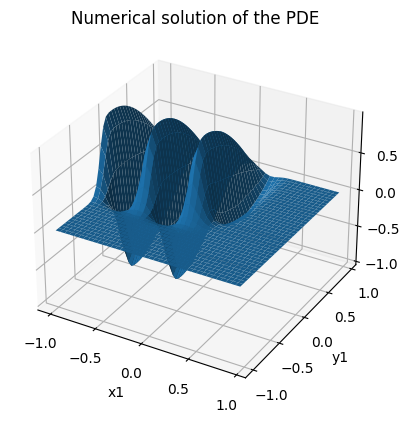

In [182]:
fig=plot_vectorized_function(models[2],0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [183]:
models[0].shared_value

{model 1: array([0.97349294, 0.73703898, 0.74235081, 0.65250526, 0.16939671,
        0.5402923 , 0.80383962, 0.43832985, 0.96682757, 0.25767355,
        0.42836375, 0.09856759, 0.32323916, 0.9763348 , 0.30588877,
        0.7566672 , 0.89291741, 0.04097832, 0.9219148 , 0.03022672,
        0.398191  , 0.56226199, 0.97569702, 0.83115436, 0.77271881,
        0.84763242, 0.80101139, 0.90711833, 0.34569508, 0.18544569,
        0.84459919]),
 model 2: array([ 0.99757113,  0.62281217,  0.59864546, -0.66649308, -0.99389912,
        -0.6526011 ,  0.64784   , -0.00116715,  0.41489988, -0.99859599,
        -0.29485466,  0.92283127, -0.16541512,  0.48909841,  0.0327041 ,
        -0.23819702, -0.14984415,  0.2962991 , -0.20862064,  0.03754724,
        -0.56744576,  0.15588175,  0.6666552 , -0.83120028,  0.1237199 ,
         0.96473054,  0.90817396, -0.55529087, -0.99792884,  0.98072394,
         0.4039826 ])}

In [184]:
model0=PDESolver(
        X_int=make_points_inside(1000),
        X_boundary=make_points_boundary(200),
        sigma=sigma,
        name=f'model 0')
model0.fit_interior(f,real_u,tau,dtau,use_shared=False,nugget=1e-5)

In [185]:
model0.a = np.concatenate(
    [
        model0.gauss_newton_solution["z"],
        model0.g_vec,
        model0.gauss_newton_solution["z_lap"],
    ]
)
model0.coeff = model0.K_inv @ model0.a

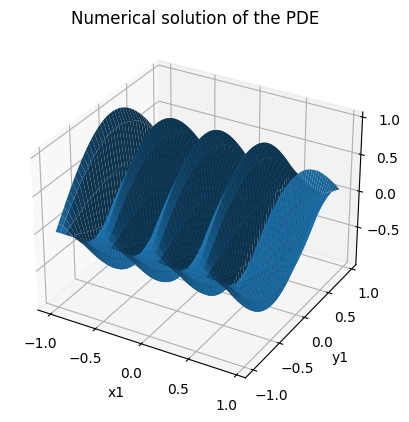

In [186]:
fig=plot_vectorized_function(model0,0.05)
plt.title('Numerical solution of the PDE')
plt.show()